# Dataset retirado do kaggle
### https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# Leitura e pré-processamento dos dados

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Portfólio/Cardiovascular Disease/cardio_train.csv', sep=';')

In [4]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
# Convertendo peso e altura em IMC
df['IMC'] = df['weight']/((df['height']/100)**2)
df['IMC'] = df['IMC'].round(1)
# Convertendo a idade de datas para anos
df['age_year'] = df['age']/365
df['age_year'] = df['age_year'].astype(int)

In [7]:
# Excluindo as colulas ano, altura, peso e id
df.drop(['age', 'height', 'weight', 'id'], axis=1, inplace=True)

In [8]:
df.describe()

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMC,age_year
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,1.349571,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,27.555311,52.840671
std,0.476838,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.092596,6.766774
min,1.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.500000,29.000000
25%,1.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.900000,48.000000
50%,1.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.400000,53.000000
75%,2.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.200000,58.000000
max,2.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.700000,64.000000


Com a descrição acima, pode-se verificar que as pressões alta e baixa (ap_hi e ap_lo), e o IMC estão com valores fora do normal (outliers)

In [9]:
# Reformulando o dataframe para o boxplot
df_melt = pd.melt(df,id_vars='cardio', value_vars=['age_year', 'ap_hi', 'ap_lo', 'IMC'],  var_name='colunas', value_name='valores', col_level=None)

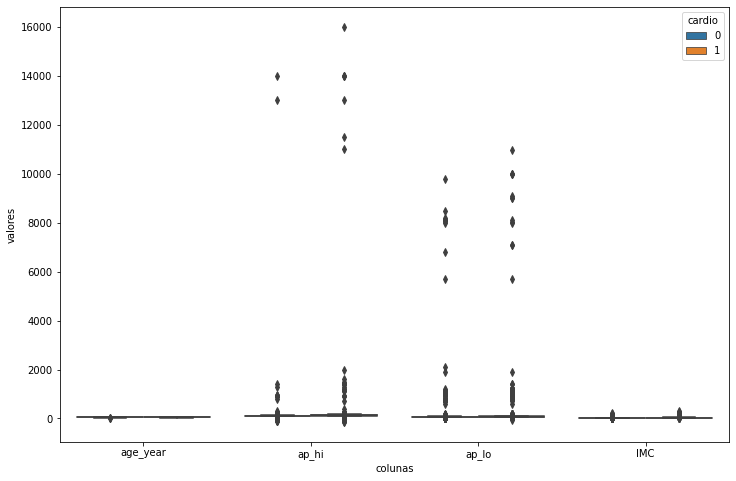

In [10]:
# Verificando os outliers com boxplot
plt.figure(figsize=(12,8))
sns.boxplot(x='colunas', y='valores', hue='cardio', data=df_melt)

### Separando os dados com base na coluna cardio

In [11]:
# Criando um dataframe para cardio igual a 0
df_c0 = df[df['cardio'] == 0]

In [12]:
# Verificando o máximo e o mínimo dos quartis para identificar os outliers
lista = ['ap_lo', 'ap_hi', 'IMC']
df_quartil = pd.DataFrame(index=['Q minimo', 'Q maximo'])

for e in lista:
    Q1 = df_c0[e].quantile(0.25)
    Q3 = df_c0[e].quantile(0.75)
    IQR = Q3 - Q1
    
    minimo = Q1 - (1.5 * IQR)
    maximo = Q3+ (1.5 * IQR)
    
    df_quartil[e]= [minimo, maximo]
    
df_quartil

,ap_lo,ap_hi,IMC
Q minimo,55.0,95.0,15.3
Q maximo,95.0,135.0,36.9


In [13]:
# Excluindo as linhas que possuem os outliers
outlier_c0 = df_c0[(df_c0['ap_lo']!=80)|(df_c0['ap_hi']>121.5)|(df_c0['ap_hi']<117.5)|(df_c0['IMC']>36.65)|(df_c0['IMC']<15.45)].index
df_c0.drop(outlier_c0, inplace=True)

In [14]:
df_c0.describe()

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMC,age_year
count,14769.000000,14769.000000,14769.0,14769.000000,14769.000000,14769.000000,14769.000000,14769.000000,14769.0,14769.000000,14769.000000
mean,1.381204,119.999932,80.0,1.148487,1.144289,0.087413,0.048345,0.817726,0.0,25.748548,51.257431
std,0.485699,0.031870,0.0,0.448255,0.472677,0.282449,0.214500,0.386083,0.0,3.559875,6.588320
min,1.000000,118.000000,80.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,15.700000,29.000000
25%,1.000000,120.000000,80.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.0,23.400000,46.000000
50%,1.000000,120.000000,80.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.0,25.000000,52.000000
75%,2.000000,120.000000,80.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.0,27.700000,56.000000
max,2.000000,121.000000,80.0,3.000000,3.000000,1.000000,1.000000,1.000000,0.0,36.600000,64.000000


In [15]:
# Criando um dataframe para cardio igual a 1
df_c1 = df[df['cardio'] == 1]

In [16]:
# Verificando o máximo e o mínimo dos quartis para identificar os outliers
lista = ['ap_lo', 'ap_hi', 'IMC']
df_quartil = pd.DataFrame(index=['Q minimo', 'Q maximo'])

for e in lista:
    Q1 = df_c1[e].quantile(0.25)
    Q3 = df_c1[e].quantile(0.75)
    IQR = Q3 - Q1
    
    minimo = Q1 - (1.5 * IQR)
    maximo = Q3+ (1.5 * IQR)
    
    df_quartil[e]= [minimo, maximo]
    
df_quartil

,ap_lo,ap_hi,IMC
Q minimo,65.0,90.0,13.85
Q maximo,105.0,170.0,42.25


In [17]:
# Excluindo as linhas que possuem os outliers
outlier_c1 = df_c1[(df_c1['ap_lo']>105)|(df_c1['ap_lo']<65)|(df_c1['ap_hi']>170)|(df_c1['ap_hi']<90)|(df_c1['IMC']>39.65)|(df_c1['IMC']<14.45)].index
df_c1.drop(outlier_c1, inplace=True)

In [18]:
df_c1.describe()

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMC,age_year
count,30933.000000,30933.000000,30933.000000,30933.000000,30933.000000,30933.000000,30933.000000,30933.000000,30933.0,30933.000000,30933.000000
mean,1.359325,132.658779,84.298355,1.505868,1.270100,0.083374,0.050593,0.789674,1.0,27.822044,54.485501
std,0.479810,14.824641,7.940665,0.772653,0.619897,0.276451,0.219169,0.407546,0.0,4.489681,6.355194
min,1.000000,90.000000,65.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,14.500000,39.000000
25%,1.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.0,24.300000,50.000000
50%,1.000000,130.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.0,27.100000,55.000000
75%,2.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.0,30.900000,60.000000
max,2.000000,170.000000,105.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.0,39.600000,64.000000


É possível verificar que as colunas, que antes possuiam outliers, agora estão com dados aceitáveis.

In [19]:
# Concatenando os dados em um único dataframe
df = pd.concat([df_c0, df_c1])

In [20]:
df_melt_new = pd.melt(df,id_vars='cardio', value_vars=['age_year', 'ap_hi', 'ap_lo', 'IMC'],  var_name='colunas', value_name='valores', col_level=None)

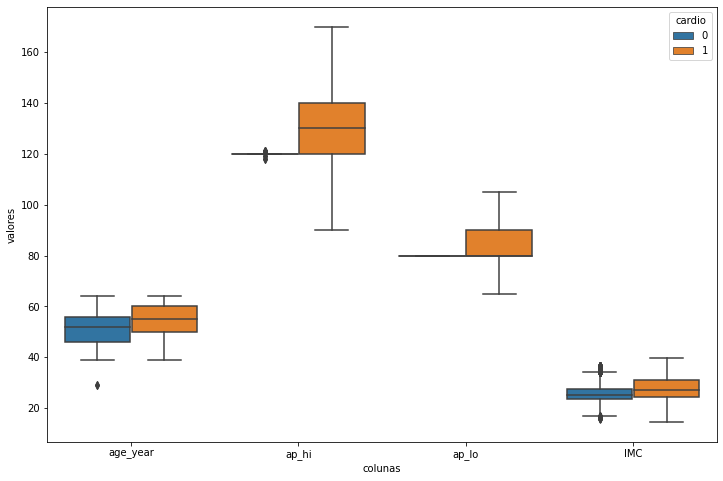

In [21]:
# Verificando se os outliers foram excluídos utilizando boxplot
plt.figure(figsize=(12,8))
sns.boxplot(x='colunas', y='valores', hue='cardio', data=df_melt_new)

Com o boxplot fica mais fácil a visualização dos novos dados sem os outliers

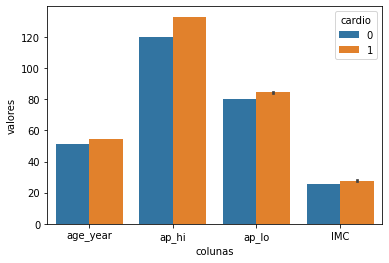

In [22]:
# Verificando a quantidade de elementos em relação a coluna alvo
sns.barplot(x='colunas', y='valores', hue='cardio',data=df_melt_new)

# Criação do modelo de Machine Learning

In [23]:
# Separando os dados entre features e target
x = df.drop('cardio', axis=1)
y = df['cardio']

In [24]:
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
std = StandardScaler()
minmax = MinMaxScaler()

### Criação dos pipelines

In [25]:

# Knn com standardScaler
pip_knn_std = Pipeline([
    ('scaler', std),
    ('clf', knn)
])

# Knn com MinMaxScaler
pip_knn_minmax = Pipeline([
    ('scaler', minmax),
    ('clf', knn)
])

# Random Forest com StandardScaler
pip_rf_std = Pipeline([
    ('scaler', std),
    ('clf', rf)
])

# Random Forest com MinMaxScaler
pip_rf_minmax = Pipeline([
    ('scaler', minmax),
    ('clf', rf)
])

In [26]:
# Criação da lista de parâmetros
lista = list(range(10, 151))
# Aplicando as listas aos parâmetros
param_knn = {'clf__n_neighbors':lista}
param_rf = {'clf__n_estimators': lista}

In [27]:
# Criação dos modelos
rs_knn_std = RandomizedSearchCV(pip_knn_std, param_knn, cv=5, verbose=1, random_state=42)
rs_knn_minmax = RandomizedSearchCV(pip_knn_minmax, param_knn, cv=5, verbose=1, random_state=42)
rs_rf_std = RandomizedSearchCV(pip_rf_std, param_rf, cv=5, verbose=1, random_state=42)
rs_rf_minmax = RandomizedSearchCV(pip_rf_minmax, param_rf, cv=5, verbose=1, random_state=42)

## Treinando os modelos e aplicando as métricas de avaliação

### Knn com standardScaler

In [28]:
# Treinamento 
rs_knn_std.fit(x, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              KNeighborsClassifier(algorithm='auto',
                                                                   leaf_size=30,
                                                                   metric='minkowski',
                                                                   metric_params=None,
                                                                   n_jobs=None,
                                                                   n_neighbors=5,
                                                                   p=

In [29]:
# Matriz de confusão
print(pd.crosstab(y, rs_knn_std.predict(x), margins=True))

col_0       0      1    All
cardio                     
0       13336   1433  14769
1        5974  24959  30933
All     19310  26392  45702


In [30]:
# Relatório das métricas de classficação
print(metrics.classification_report(y, rs_knn_std.predict(x)))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78     14769
           1       0.95      0.81      0.87     30933

    accuracy                           0.84     45702
   macro avg       0.82      0.85      0.83     45702
weighted avg       0.86      0.84      0.84     45702



### Knn com MinMaxScaler

In [31]:
# Treinamento
rs_knn_minmax.fit(x, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              MinMaxScaler(copy=True,
                                                           feature_range=(0,
                                                                          1))),
                                             ('clf',
                                              KNeighborsClassifier(algorithm='auto',
                                                                   leaf_size=30,
                                                                   metric='minkowski',
                                                                   metric_params=None,
                                                                   n_jobs=None,
                                                                   n_neighbors=5,
                                                                   p=

In [32]:
# Matriz de confusão
print(pd.crosstab(y, rs_knn_minmax.predict(x), margins=True))

col_0       0      1    All
cardio                     
0       13202   1567  14769
1        5914  25019  30933
All     19116  26586  45702


In [33]:
# Relatório das métricas de classficação
print(metrics.classification_report(y, rs_knn_minmax.predict(x)))

              precision    recall  f1-score   support

           0       0.69      0.89      0.78     14769
           1       0.94      0.81      0.87     30933

    accuracy                           0.84     45702
   macro avg       0.82      0.85      0.82     45702
weighted avg       0.86      0.84      0.84     45702



### Random Forest com StandardScaler

In [34]:
# Treinamento
rs_rf_std.fit(x, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                    

In [35]:
# Matriz de confusão
print(pd.crosstab(y, rs_rf_std.predict(x), margins=True))

col_0       0      1    All
cardio                     
0       13823    946  14769
1        2189  28744  30933
All     16012  29690  45702


In [36]:
# Relatório das métricas de classificação
print(metrics.classification_report(y, rs_rf_std.predict(x)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     14769
           1       0.97      0.93      0.95     30933

    accuracy                           0.93     45702
   macro avg       0.92      0.93      0.92     45702
weighted avg       0.93      0.93      0.93     45702



### Random Forest com MinMaxScaler

In [37]:
# Treinamento
rs_rf_minmax.fit(x, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              MinMaxScaler(copy=True,
                                                           feature_range=(0,
                                                                          1))),
                                             ('clf',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                    

In [38]:
# Matriz de confusão
print(pd.crosstab(y, rs_rf_minmax.predict(x), margins=True))

col_0       0      1    All
cardio                     
0       13825    944  14769
1        2191  28742  30933
All     16016  29686  45702


In [39]:
# Relatório das métricas de classificação
print(metrics.classification_report(y, rs_rf_minmax.predict(x)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     14769
           1       0.97      0.93      0.95     30933

    accuracy                           0.93     45702
   macro avg       0.92      0.93      0.92     45702
weighted avg       0.93      0.93      0.93     45702



Os dois modelos feitos com Random forest possuem as maiores precisões, com 93%, enquando as com KNN atingiu 84%.  
Ambos levando em consideração a acurácia do F1-score no relatório das métricas de classificação